<a href="https://colab.research.google.com/github/mylethidiem/artificial-intelligence-projects/blob/main/Architecture%20Project%20Gradient%20Vanishing%20in%20MLP/_OriginalModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **0. Import libraries**

import các thư viện cần thiết cho việc xử lý dữ liệu, xây dựng mô hình và các công cụ hỗ trợ

In [ ]:
import random
import matplotlib.pyplot as plt # truc quan hoa
import numpy as np

import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import FashionMNIST #download fashion mnist data


Xác định phần cứng và cố định tham số ngẫu nhiên: Để đảm bảo kết quả mô hình huấn luyện được là như nhau khi bắt đầu chạy chương trình ở bất kỳ Google Colab nào, chúng ta cần cố định tham số ngẫu nhiên seed cho mọi thư viện liên quan


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

SEED = 42
set_seed(SEED)

## **1. Prepare dataset**


Bộ dữ liệu Fashion MNIST là một tập dữ liệu phổ biến, bao gồm các hình ảnh grayscale 28x28 của các loại quần áo, được sử dụng để phân loại mười nhãn khác nhau:
- 1: T-shirt/top
- 2: Trouser
- 3: Pullover
- 4: Dress
- 5: Coat
- 6: Sandal
- 7: Shirt
- 8: Sneaker
- 9: Bag
- 10: Ankle boot

Pytorch cung cấp hàm tải tự động cho bộ dữ liệu này. Chúng ta sẽ tiến hành quá trình tải và chuyển dữ liệu sang Tensor.

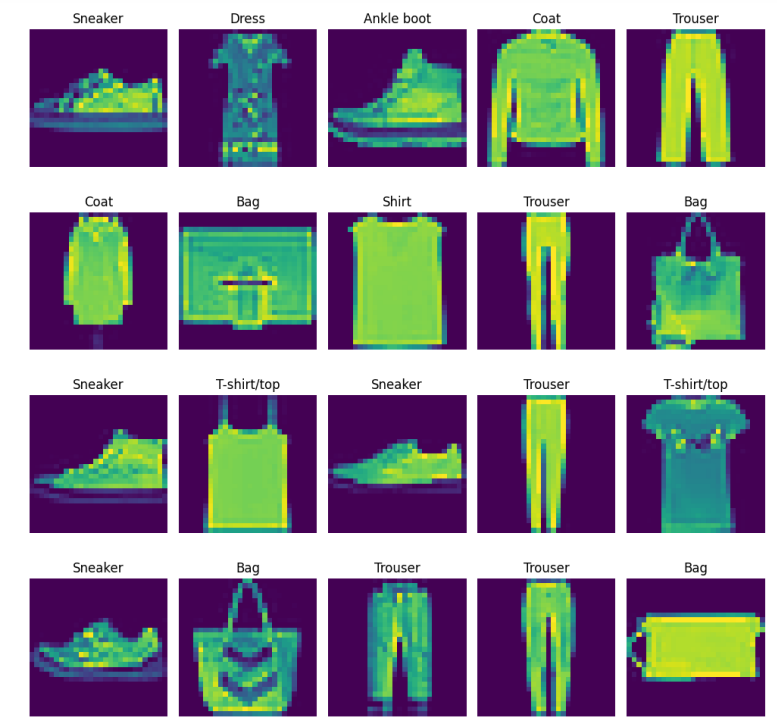

In [ ]:
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

Chia bộ dữ liệu train/val/test. ta chia bộ train thành 2 phần với tỷ lệ chia là 90% cho cho train và 10% cho validation. Các tập dữ liệu này sau đó được gói vào DataLoader để dễ dàng sử dụng trong quá trình huấn luyện.

In [ ]:
train_ratio = 0.9
# train_size là số lượng mẫu dữ liệu dùng để train (54000 mẫu = 90% của tập train_dataset)
train_size = int(train_ratio * len(train_dataset)) #90%
val_size = len(train_dataset) - train_size #10%

# train_subset là tập dữ liệu con được tạo ra bằng cách chia ngẫu nhiên train_dataset thành 2 phần
# Hàm random_split() chia train_dataset thành 2 tập con:
# - train_subset: chứa train_size mẫu (54000 mẫu)
# - val_subset: chứa val_size mẫu (6000 mẫu)
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
# Tại sao lại shuffle tập data train?
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(f"Train size: {len(train_subset)}")
print(f"Validation size: {len(val_subset)}")
print(f"Test size: {len(test_dataset)}")

## **2. Build MLP network**




Xây dựng mạng MLP với nhiều lớp ẩn. Mỗi lớp ẩn được nối tiếp bởi hàm kích hoạt Sigmoid. Mô hình có số lớp ẩn là 7, mỗi lớp ẩn sẽ có 128 node và hàm kích hoạt được sử dụng là hàm Sigmoid. Sau khi định nghĩa kiến trúc mạng, chúng ta sẽ khởi tạo mô hình và khai báo hàm mất mát (CrossEntropyLoss) cùng thuật toán tối ưu ([SGD](https://viblo.asia/p/optimizer-hieu-sau-ve-cac-thuat-toan-toi-uu-gdsgdadam-Qbq5QQ9E5D8))

In [ ]:
class MLP(nn.Module):
  def __init__(self, input_dims, hidden_dims, output_dims):
    super(MLP, self).__init__()
    self.layer1 = nn.Linear(input_dims, hidden_dims)#
    self.layer2 = nn.Linear(hidden_dims, hidden_dims)
    self.layer3 = nn.Linear(hidden_dims, hidden_dims)
    self.layer4 = nn.Linear(hidden_dims, hidden_dims)
    self.layer5 = nn.Linear(hidden_dims, hidden_dims)
    self.layer6 = nn.Linear(hidden_dims, hidden_dims)
    self.layer7 = nn.Linear(hidden_dims, hidden_dims)
    self.output = nn.Linear(hidden_dims, output_dims)

  def forward(self, x):
    x = nn.Flatten()(x)
    x = self.layer1(x)
    x = nn.Sigmoid()(x)
    x = self.layer2(x)
    x = nn.Sigmoid()(x)
    x = self.layer3(x)
    x = nn.Sigmoid()(x)
    x = self.layer4(x)
    x = nn.Sigmoid()(x)
    x = self.layer5(x)
    x = nn.Sigmoid()(x)
    x = self.layer6(x)
    x = nn.Sigmoid()(x)
    x = self.layer7(x)
    x = nn.Sigmoid()(x)
    out = self.output(x)
    return out

input_dims = 784 #28x28 pixel = 784 pixel
#2^7:giá trị đủ lớn để có thể học đc các đặc trưng phức tạp, không quá lớn để bị overfitting
hidden_dims = 128
output_dims = 10 #10 class
lr = 1e-2
model = MLP(input_dims, hidden_dims, output_dims).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

## **3. Training**

Huấn luyện mô hình: quá trình huấn luyện mô hình bao gồm 2 giai đoạn: train và validation.
Chuẩn bị đầy đủ các thành phần cần thiết:
- Mô hình
- DataLoader
- Hàm mất mát
- Thuật toán tối ưu

Kết quả được lưu lại để phục vụ việc đánh giá và trực quan hóa sau này.

In [ ]:
# Số lượng epochs (chu kỳ huấn luyện) cho quá trình training
# Mỗi epoch, mô hình sẽ được huấn luyện trên toàn bộ tập dữ liệu training một lần
# Với epochs = 100, mô hình sẽ được huấn luyện 100 lần trên tập dữ liệu
epochs = 100
train_loss_lst =[]
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

# Lặp qua số epochs đã định
for epoch in range(epochs):
  # Khởi tạo các biến để tính loss và accuracy cho tập train
  train_loss = 0
  train_acc = 0
  count = 0
  # Chuyển model sang chế độ train
  model.train()
  # Lặp qua từng batch dữ liệu train
  for X_train, y_train in train_loader:
    # Chuyển dữ liệu sang device (GPU/CPU)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    # Xóa gradient tích lũy từ bước trước
    optimizer.zero_grad()
    # Forward pass: tính output của model
    outputs = model(X_train)
    # Tính loss giữa output và ground truth
    loss = criterion(outputs, y_train)
    # Backward pass: tính gradient
    loss.backward()
    # Cập nhật trọng số dựa trên gradient
    optimizer.step()
    # Cộng dồn loss và accuracy
    train_loss += loss.item()
    # Tính số lượng dự đoán đúng trong batch hiện tại:
    # 1. torch.argmax(outputs,1): Lấy chỉ số của giá trị lớn nhất trên mỗi hàng (dim=1) của outputs
    #    -> Đây chính là nhãn được dự đoán bởi mô hình
    # 2. == y_train: So sánh với nhãn thực tế, trả về tensor boolean (True nếu dự đoán đúng)
    # 3. .sum(): Đếm số lượng giá trị True (số lượng dự đoán đúng)
    # 4. .item(): Chuyển đổi tensor thành số Python
    # Cộng dồn số lượng dự đoán đúng vào biến train_acc
    train_acc += (torch.argmax(outputs,1) == y_train).sum().item()
    count += len(y_train)
  # Tính trung bình loss và accuracy trên tập train
  train_loss /= len(train_loader)
  train_loss_lst.append(train_loss)
  train_acc /= count
  train_acc_lst.append(train_acc)

  # Khởi tạo các biến để tính loss và accuracy cho tập validation
  val_loss = 0.0
  val_acc = 0.0
  count = 0
  # Chuyển model sang chế độ evaluation
  model.eval()
  # Tắt tính toán gradient khi validate vì:
  # 1. Không cần cập nhật trọng số trong quá trình validation
  # 2. Giúp tăng tốc độ tính toán và tiết kiệm bộ nhớ
  # 3. Đảm bảo kết quả đánh giá nhất quán vì không có sự thay đổi của trọng số
  with torch.no_grad():
    # Lặp qua từng batch dữ liệu validation
    for X_val, y_val in val_loader:
      # Chuyển dữ liệu sang device
      X_val = X_val.to(device)
      y_val = y_val.to(device)
      # Tính output
      outputs = model(X_val)
      # Tính loss
      loss = criterion(outputs, y_val)
      # Cộng dồn loss và accuracy
      val_loss += loss.item()
      val_acc += (torch.argmax(outputs,1) == y_val).sum().item()
       # Train size có thể khác so với tổng số mẫu thực tế dùng(do loại bỏ mẫu lỗi..?)
      count += len(y_val)
  # Tính trung bình loss và accuracy trên tập validation
  val_loss /= len(val_loader)
  val_loss_lst.append(val_loss)
  val_acc /= count # Chia cho số mẫu thực tế đã sử dụng
  val_acc_lst.append(val_acc)

  # In kết quả sau mỗi epoch
  print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f},Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f} , Val_Acc:{val_acc:.4f}")

Trực quan hóa kết quả huấn luyện: bên dưới là biểu đồ Loss và Accuracy cho cả tập train và validation

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

Trực quan hóa hiệu suất mô hình baseline trong quá trình training. Có thể thấy mô hình không thể đạt sự hội tụ tốt do vướng phải hiện tượng Vanishing Gradient

## **4. Evaluation**

Sau khi đã huấn luyện mô hình và kiểm tra trên tập validation, chúng ta cần đánh giá hiểu suất của mô hình trên tập test thông qua sử dụng dụng độ đo Accuracy để kiểm tra khả năng phân loại của mô hình trên dữ liệu khác.

In [ ]:
# Khởi tạo list rỗng để lưu trữ nhãn thực tế của tập test
# Sau đó sẽ được sử dụng để so sánh với dự đoán của mô hình
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
  for X_test, y_test in test_loader:
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    outputs = model(X_test)

    test_target.append(y_test.cpu())# ko cần tính toán trên GPU nữa
    test_predict.append(outputs.cpu())

# Ghép các batch của nhãn thực tế và dự đoán thành một tensor duy nhất
# Shape: (batch_size, channels, height, width)
# dim=0: ghép theo batch
# dim=1: ghép theo kênh màu
# dim=2: ghép theo chiều cao
# dim=3: ghép theo chiều rộng

# Tensor 2D thông thường:
#dim=0  # Ghép theo hàng (vertically)
#dim=1  # Ghép theo cột (horizontally)

# Tensor nhiều chiều:
#dim=n  # n là chỉ số của chiều muốn ghép (0-based indexing)
test_target = torch.cat(test_target, dim=0) #ghép theo chiều thứ nhất chiều batch(chiều dọc)
test_predict = torch.cat(test_predict, dim=0)

# Tính độ chính xác trên tập test:
# 1. torch.argmax(test_predict,1) - Lấy chỉ số của giá trị lớn nhất trên mỗi hàng (dự đoán của mô hình)
# 2. So sánh với nhãn thực tế (test_target)
# 3. Tính tổng số dự đoán đúng và chia cho tổng số mẫu
test_acc = (torch.argmax(test_predict,1)==test_target).sum().item()/len(test_target)
print(f"Test Accuracy: {test_acc:.4f}")

## **5. Methods for Improving**

Chúng ta sẽ triển khai code cài đặt các phương pháp cải tiến nhằm giảm thiểu vấn đề Vanishing gradient trong baseline model.

1. Weight inscreasing \
Kỹ thuật này tập trung vào việc khởi tạo trọng số ban đầu với các giá trị lớn hơn nhằm tăng giá trị gradient trong các bước lan truyền ngược. \
Khởi tạo trọng số với phân phối chuẩn (normal distribution) và sử dụng hai thiết lập khác nhau để đánh giá tác động: một với độ lệch chuẩn (std) là 1.0 và một với std là 10.0.

[Link code: std = 1.0](https://colab.research.google.com/github/mylethidiem/artificial-intelligence-projects/blob/main/Architecture%20Project%20Gradient%20Vanishing%20in%20MLP/1.1_WeightIncreasing.ipynb) \
[Link code: std = 10.0](https://colab.research.google.com/github/mylethidiem/artificial-intelligence-projects/blob/main/Architecture%20Project%20Gradient%20Vanishing%20in%20MLP/1.2_WeightIncreasing.ipynb)

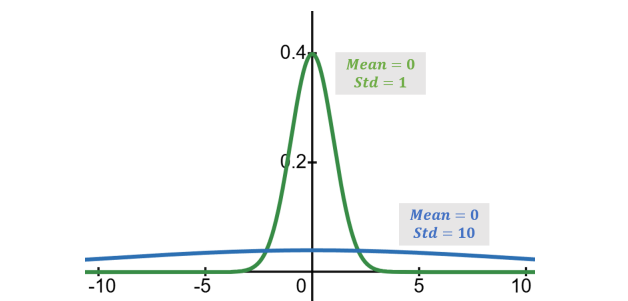

2. Better Activation \
Thay đổi các hàm kích hoạt trong mạng thành các hàm tiên tiến hơn. Những hàm này có khả năng hạn chế hiện tượng bão hòa, giúp gradient duy trì giá trị hợp lý qua các mạng. \
Ở đây ta triển khai ý tưởng này bằng cách thay thế hàm Sigmoid trong mạng baseline bằng ReLU. Ngoài ra, trọng số của các lớp Linear cũng được khởi tạo với độ lệch chuẩn nhỏ hơn(std=0.05) để phù hợp với tính chất của ReLU. \
[Link code](https://colab.research.google.com/github/mylethidiem/artificial-intelligence-projects/blob/main/Architecture%20Project%20Gradient%20Vanishing%20in%20MLP/2_BetterActivationFunction.ipynb)

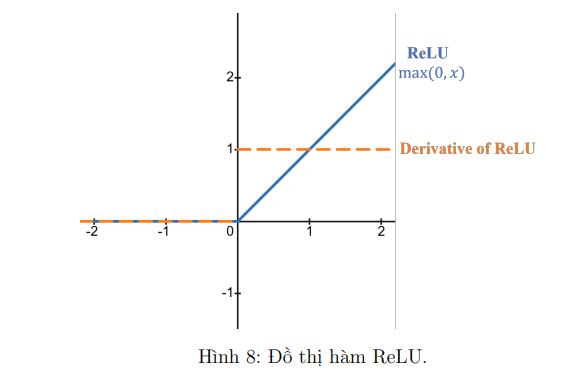

3. Better Optimizer \
Lựa chọn thuật toán tối ưu phù hợp hơn có thể giúp cải thiện vấn đề Vanishing Gradient. \
Tại đây chúng ta thay SGD bằng Adam một thuật toán hiện đại với khả năng tự điều chỉnh tốc độ học. \
[Link code](https://colab.research.google.com/github/mylethidiem/artificial-intelligence-projects/blob/main/Architecture%20Project%20Gradient%20Vanishing%20in%20MLP/3_BetterOptimizer.ipynb)

4. Normalize Inside Network \
Batch Normalization là một kỹ thuật phổ biến để giữ các đầu vào của từng lớp mạng trong khoảng ổn định, giúp gradient không bị triệt tiêu hoặc phóng đại, tăng tốc độ hội tụ và cải thiện khả năng tổng quát hóa của mô hình. Chúng ta sẽ thử nghiệm 2 kỹ thuật normalization: \

    a. Normalize Inside Network \
    Batch Normalization giúp chuẩn hóa đầu ra của từng lớp, giữ giá trị trong khoảng ổn định và cải thiện tốc độ hội tụ. \
    [Link code](https://colab.research.google.com/github/mylethidiem/artificial-intelligence-projects/blob/main/Architecture%20Project%20Gradient%20Vanishing%20in%20MLP/4_NormalizationInsideNetwork.ipynb) \
    b. Customized Normalization Layer \
    Xây dựng một class normalizaition mới.

5. Skip Connection \
Được giới thiệu trong kiến trúc mạng [ResNet](https://arxiv.org/pdf/1512.03385), giúp gradient có thể lan truyền ngược qua các lớp mà không bị triệt tiêu. Chúng ta triển khai skip connections bằng cách cộng đầu ra của các lớp trước với các lớp tiếp theo tại một số điểm trong mạng. \
[Link code](https://colab.research.google.com/github/mylethidiem/artificial-intelligence-projects/blob/main/Architecture%20Project%20Gradient%20Vanishing%20in%20MLP/5_SkipConnection.ipynb)

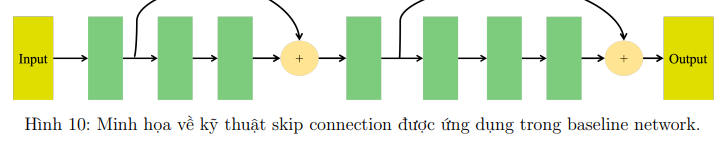

6. Train Layers Separately (fine-tuning) \
Trong các mạng rất sâu, việc huấn luyện toàn bộ các lớp có thể dẫn đến hiệu suất thấp do vấn đề Vanishing Gradient. Bằng cách chỉ huấn luyện một số lớp cụ thể, mô hình có thể tập trung vào việc học các đặc trưng quan trọng hơn và không bị ảnh hưởng bởi các lớp sâu hơn.(Need reference link) \
Mô hình ban đầu sẽ được chia thành các mô hình con với số lượng layer cụ thể. \
(a) Xây dựng các module thành phần \
(b) Khởi tạo các module thành phần \
[Link code](https://colab.research.google.com/github/mylethidiem/artificial-intelligence-projects/blob/main/Architecture%20Project%20Gradient%20Vanishing%20in%20MLP/6_TrainLayersSeparately.ipynb)

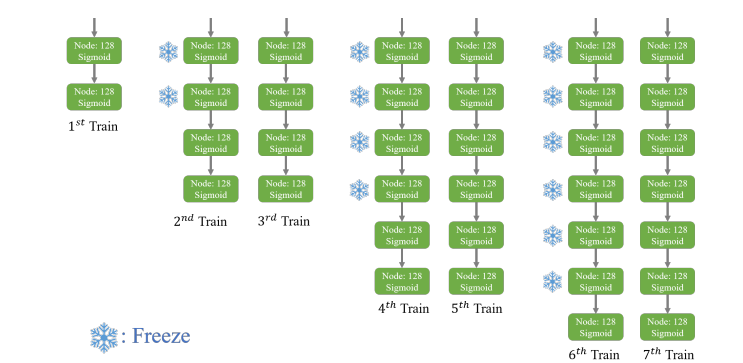

Hình trên cho thấy lần lượt huấn luyện các mô hình con. Sau khi một mô hình con đã huấn luyện xong, ta đóng băng trọng số đã train cho mô hình, kết nối mô hình tiếp theo và tiếp tục quá trình training. \
(c) Giai đoạn 1 - Huấn luyện chỉ với thành phần đầu tiên \
(d) Giai đoạn 2 - Thêm thành phần thứ 2. Cố định thành phần first. \
(e) Giai đoạn 3 - Cập nhật toàn bộ thành phần hiện có: Khi đã huấn luyện riêng cho thành phần second, ta huấn luyện lại toàn bộ mạng hiện có mà không cố định thành phần nào. \
(f) Giai đoạn 4 - Thêm thành phần thứ 3. Cố định first và second. Chỉ huấn luyện riêng cho thành phần mới. \
(g) Giai đoạn 5 - Cập nhật toàn bộ thành phần hiện có. \
(h) Giai đoạn 6 - Thêm thành phần thứ 4. Cố định first, second và third. Chỉ huấn luyện riêng cho thành phần mới. \
(i) Giai đoạn 7 - Mở khóa toàn bộ toàn phần. Sau khi đã thêm đủ các thành phần, chúng ta mở khóa tất các lớp trong mạng và thực hiện huấn luyện toàn bộ mô hình. Điều này đảm bảo rằng tất cả các lớp đều được tối ưu hóa chung để đạt hiệu suất tốt nhất.

7. Gradient Normalization \
Là một kỹ thuật với ý tưởng chuẩn hóa Gradient trong quá trình lan truyền ngược. \
Cài đặt một lớp GradientNormalizationLayer, sử dụng cơ chế autograd của PyTorch để chuẩn hóa gradient trong giai đoạn lan truyền ngược. Cụ thể, gradient được điều chỉnh bằng cách chuẩn hóa theo trung bình và độ lệch chuẩn của nó. \
Tích hợp lớp này vào các mạng MLP hiện có bằng cách sử dụng nó sau các lớp Linear, đảm bảo rằng gradient được chuẩn hóa trước khi lan truyền ngược qua các lớp. \

[Link code](https://colab.research.google.com/github/mylethidiem/artificial-intelligence-projects/blob/main/Architecture%20Project%20Gradient%20Vanishing%20in%20MLP/7_GradientNorm.ipynb#scrollTo=bb96f0ec-3525-4e79-9ad1-8e95c15a9cf2)


